In [87]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [88]:
# Setting  device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 1: Loading data

data = pd.read_csv('merged_data.csv_2.csv')
data.drop(columns=['Nearby_POI_Weight'], inplace=True)
data =data.sample(frac=0.1, random_state=42)

Using device: cuda


In [89]:

# Handling outliers in the target
z_scores = np.abs((data['Loyer médian (€/m²)'] - data['Loyer médian (€/m²)'].mean()) / data['Loyer médian (€/m²)'].std())
data = data[z_scores <= 3]

# Ensuring target is numeric
data['Loyer médian (€/m²)'] = data['Loyer médian (€/m²)'].astype(float)


In [90]:
# Step 5: Ensuring Numeric Type
data['Loyer médian (€/m²)'] = data['Loyer médian (€/m²)'].astype(float)

In [91]:
# Step 3: Defining features and target
text_features = ['cle_interop', 'commune_nom', 'voie_nom', 'Adresse']
categorical_features = ['Nombre de pièces', 'Époque de construction', 'Type de location']
numerical_features = [
    'lat', 'long','numero', 'num_dentist', 'num_driving_school', 'num_park',
    'num_fitness_centre', 'num_pub', 'num_community_centre',
    'num_yoga_studio', 'num_dojo', 'num_sports_centre'
]
target = 'Loyer médian (€/m²)'


In [92]:
X_text = data[text_features]
X_num = data[numerical_features]
y = data[target]


# Separating features and target
X_text = data[text_features]
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
y = data[target]


In [93]:
# Combining text and numerical features into a single dataset
X_combined = pd.concat([X_text,X_categorical, X_numerical], axis=1)

In [94]:
# Splitting combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)


In [95]:
# Separating  back into components for preprocessing
X_train_text = X_train[text_features]
X_train_categorical = X_train[categorical_features]
X_train_numerical = X_train[numerical_features]

X_test_text = X_test[text_features]
X_test_categorical = X_test[categorical_features]
X_test_numerical = X_test[numerical_features]

In [96]:

# Initialize TextVectorization for text features
text_vectorizer = TextVectorization(output_mode="tf-idf", max_tokens=10000)

# Prepare text data for vectorization
text_data_train = X_train[text_features].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
text_data_test = X_test[text_features].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Adapt TextVectorization layer
text_vectorizer.adapt(tf.convert_to_tensor(text_data_train))

# Vectorize text features
X_train_text_vectorized = text_vectorizer(tf.convert_to_tensor(text_data_train)).numpy()
X_test_text_vectorized = text_vectorizer(tf.convert_to_tensor(text_data_test)).numpy()

# Encode categorical features
categorical_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_categorical_encoded = categorical_encoder.fit_transform(X_train[categorical_features])
X_test_categorical_encoded = categorical_encoder.transform(X_test[categorical_features])

# Scale numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_numerical_scaled = scaler.transform(X_test[numerical_features])

# Ensure all data types are float32 for TensorFlow compatibility
X_train_categorical_encoded = tf.convert_to_tensor(X_train_categorical_encoded, dtype=tf.float32)
X_test_categorical_encoded = tf.convert_to_tensor(X_test_categorical_encoded, dtype=tf.float32)
X_train_numerical_scaled = tf.convert_to_tensor(X_train_numerical_scaled, dtype=tf.float32)
X_test_numerical_scaled = tf.convert_to_tensor(X_test_numerical_scaled, dtype=tf.float32)
X_train_text_vectorized = tf.convert_to_tensor(X_train_text_vectorized, dtype=tf.float32)
X_test_text_vectorized = tf.convert_to_tensor(X_test_text_vectorized, dtype=tf.float32)

# Combine all features
X_train_combined = tf.concat(
    [X_train_numerical_scaled, X_train_text_vectorized, X_train_categorical_encoded], axis=1
)
X_test_combined = tf.concat(
    [X_test_numerical_scaled, X_test_text_vectorized, X_test_categorical_encoded], axis=1
)

print(f"Shape of combined training features: {X_train_combined.shape}")
print(f"Shape of combined testing features: {X_test_combined.shape}")


Shape of combined training features: (12179, 4252)
Shape of combined testing features: (3045, 4252)


In [97]:
input_size = X_test_combined.shape[1]
print(input_size)

4252


In [98]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert target to TensorFlow tensors
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

# Define the model
def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    return model

# Initialize the model
model = create_model(X_train_combined.shape[1])

# Compile the model
model.compile(optimizer=Adam(learning_rate=5e-5), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_combined,
    y_train_tensor,
    validation_data=(X_test_combined, y_test_tensor),
    epochs=10,
    batch_size=16,
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test_combined).flatten()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


Epoch 1/10


c:\Users\ShineOfDefender\Documents\Au513\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


762/762 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 553.8693 - mae: 22.8662 - val_loss: 22.4094 - val_mae: 3.6891
Epoch 2/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 29.7679 - mae: 4.3102 - val_loss: 8.7851 - val_mae: 2.2034
Epoch 3/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 19.1804 - mae: 3.4694 - val_loss: 6.8705 - val_mae: 1.9257
Epoch 4/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 17.5106 - mae: 3.3304 - val_loss: 6.2002 - val_mae: 1.8454
Epoch 5/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 16.5597 - mae: 3.2189 - val_loss: 6.4139 - val_mae: 1.9158
Epoch 6/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 15.5602 - mae: 3.1144 - val_loss: 6.3688 - val_mae: 1.9026
Epoch 7/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.8101 - mae: 3.0470 - val_loss: 6.1523 - val_mae: 1.8768
Epoch 8/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.1272 - mae: 2.9902 - val_loss: 6.1741 - val_mae: 1.8820
Epoch 9/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

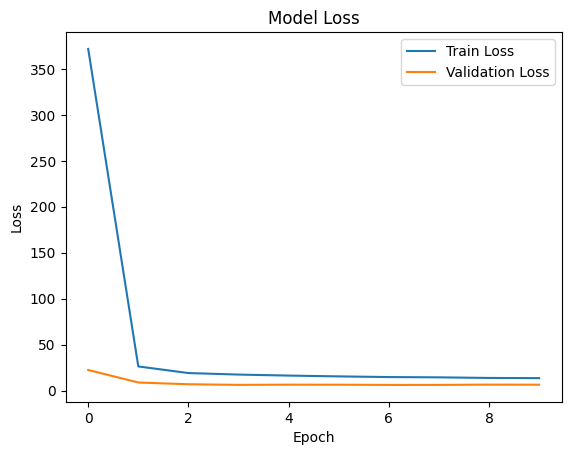

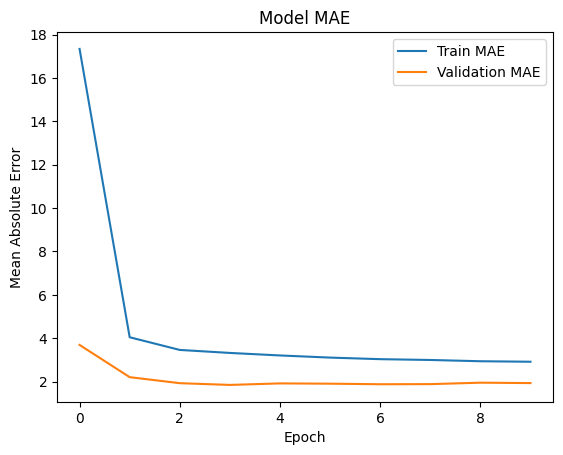

In [99]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


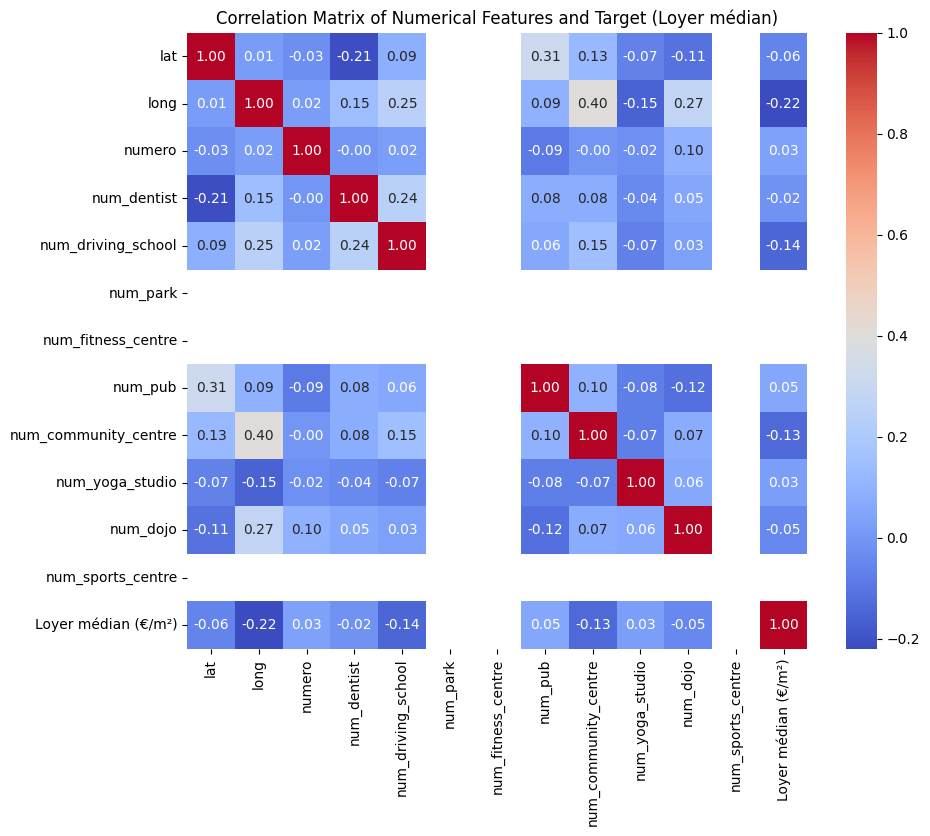

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix on the numerical features and target column
correlation_data = data[numerical_features + [target]]
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features and Target (Loyer médian)")
plt.show()


Type de location
non meublée    25.177616
meublée        25.883392
Name: Loyer médian (€/m²), dtype: float64


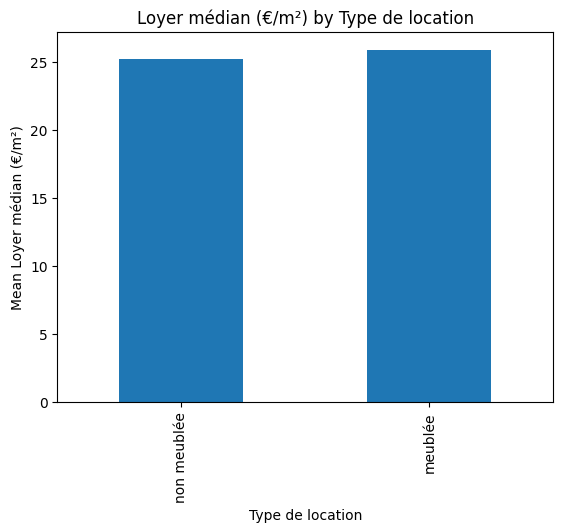

In [101]:
# Example: Analyzing the impact of `Type de location` on the target
mean_rent_by_type = data.groupby('Type de location')['Loyer médian (€/m²)'].mean().sort_values()
print(mean_rent_by_type)

# Plot
mean_rent_by_type.plot(kind='bar', title='Loyer médian (€/m²) by Type de location')
plt.ylabel('Mean Loyer médian (€/m²)')
plt.show()

In [102]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Train a simple XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Feature importance
importance = pd.Series(xgb_model.feature_importances_, index=numerical_features).sort_values(ascending=False)
print(importance)

# Plot feature importance
importance.plot(kind='bar', title='Feature Importance')
plt.ylabel('Importance Score')
plt.show()


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:cle_interop: object, commune_nom: object, voie_nom: object, Adresse: object, Nombre de pièces: object, Époque de construction: object, Type de location: object